In [1]:
import pandas as pd
import argparse
import logging
import json
import os
import pathlib
import fiona
import numpy as np
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from geopandas.tools import geocode
from shapely.geometry import Point
import requests
from zipfile import ZipFile
from tqdm import trange, tqdm

In [2]:
def get_pop(communes):
    com_pop = data_pop[data_pop["Num_Comune"].isin(communes)]# GGDENR Numéro OFS de la commune district_limits[district_limits['NAME'].isin(TI_districts)]
    com_pop = com_pop.reset_index(drop =True)
    d_pop = com_pop["Stato della popolazione al 31 dicembre"].sum()
    com_pop["percent of disrict pop"] = round((com_pop["Stato della popolazione al 31 dicembre"]/d_pop),2)
    
    return com_pop

In [3]:
def get_coordinates(comune):
    base_url = "https://api3.geo.admin.ch/rest/services/api/SearchServer"
    params = {
        "searchText": comune,
        "type": "locations",
        "lang": "en",
        "limit": 1,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Check for any request errors
        data = response.json()

        # Extract longitude and latitude from the first result
        if "results" in data and len(data["results"]) > 0:
            result = data["results"][0]
            longitude = result["attrs"]["lon"]
            latitude = result["attrs"]["lat"]
            return latitude, longitude
        else:
            print("No results found for Lugano.")
            return None, None

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None, None

In [40]:
## GET temeperature in 2020 for a comune - WORKS!
def get_weather(lat, lon, START_DATE, END_DATE, com):
    
    API_URL = "https://archive-api.open-meteo.com/v1/archive?"

    # Parameters for the API request
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m",
        "start_date": START_DATE,
        "end_date": END_DATE,
        "model": "gfs",
        "timezone": "Europe/Zurich"
    }

    response = requests.get(API_URL, params=params)

    temp = json.loads(response.text)

    temp_2 = pd.DataFrame.from_dict(temp)
    temp_2.reset_index(inplace=True) #

    weather = pd.DataFrame()
    column_name = "temperature_2m"
    weather["time"] = temp_2.at[0, "hourly"]
    weather[column_name] = temp_2.at[1, "hourly"]
    weather.set_index("time", inplace=True)
    weather.index = pd.to_datetime(weather.index)

    return weather

In [39]:
def get_HDD(weather, com):
    # Reference temperature (in Celsius)
    reference_temperature = 20

    # Calculate daily average temperature
    daily_average_temperature = weather.resample('D').mean()

    HDD_df = daily_average_temperature[daily_average_temperature["temperature_2m"] <= 12]
    
    # Calculate Heating Degree Days
    HDD = (reference_temperature - HDD_df) #.clip(lower=0)
    HDD_tot = HDD.sum()
    
    return HDD_tot

In [98]:
## Calculating the weighted HDD per district - WORKS

pathlib.Path()
NOTEBOOK_PATH = pathlib.Path().resolve()
p = NOTEBOOK_PATH.parent
DATA_DIRECTORY = p / "data"
MAP_DIRECTORY = DATA_DIRECTORY /'maps'
BLDG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'
CANTON = "Ticino"
CANTON_CSV_DIRECTORY = BLDG_DIRECTORY / CANTON

START_DATE = "2020-01-01"
END_DATE = "2020-12-31"

sup_file = DATA_DIRECTORY / "support_data" 
# reading population data
data_pop = pd.read_excel(sup_file/"pop_TI.xlsx", sheet_name = "pop_c", header=0)
data_pop = data_pop[["Num_Comune", "Nome_Comune" , "Stato della popolazione al 31 dicembre"]]

UST_file = "UST_comune.csv"
canton ="TI"
UST_comune = pd.read_csv(MAP_DIRECTORY/UST_file)
UST_comune = UST_comune[UST_comune['Cantone'] == canton].reset_index()
UST_district = UST_comune['Numero del Distretto'].drop_duplicates().reset_index(drop=True)

c_data = pd.DataFrame()
d_data=pd.DataFrame()

for dis_num in UST_district:
    DISTRICT = str(UST_comune.loc[(UST_comune["Numero del Distretto"] == dis_num), "Nome del Distretto"].iloc[0])
    com_name = UST_comune.loc[UST_comune["Numero del Distretto"] == dis_num, "Nome del Comune"] 
    com_num = UST_comune.loc[UST_comune["Numero del Distretto"] == dis_num, "Numero UST del Comune"] #
    c_pop = get_pop(com_num)
    c_pop.set_index("Nome_Comune", inplace = True)
    
    for com in com_name:
        c_lat, c_lon = get_coordinates(com)
        c_weather = get_weather(c_lat, c_lon,START_DATE, END_DATE, com)
        c_HDD = get_HDD(c_weather, com)
        c = pd.DataFrame(c_HDD).rename(index={"temperature_2m":com}, columns={0:"HDD"})
        c_data = pd.concat([c_data, c])
        
#    d_HDD = pd.concat([c_pop, c_data], axis=1)
    d_HDD = c_data.join(c_pop)
    d_HDD["w_HDD"] = d_HDD["HDD"]*d_HDD["percent of disrict pop"]
    d_pw_HDD= pd.DataFrame(data = (d_HDD["w_HDD"].sum()), index = ["pw_HDD"], columns =[DISTRICT])
    d_data = pd.concat([d_data, d_pw_HDD], axis=1)
    
    avg_HDD = d_data.loc["pw_HDD"].mean()
    d_data.loc["r_HDD"] = d_data.loc["pw_HDD"] /avg_HDD
   
    c_data = c_data[0:0]

path = str(DATA_DIRECTORY)+ "/support_data/district_pop_weighted_HDD.csv"
filepath = pathlib.Path(path)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
d_data.to_csv(filepath, sep=";", encoding='utf-8-sig', index_label='index')

# TESTS

In [96]:
path = str(DATA_DIRECTORY)+ "/support_data/district_pop_weighted_HDD.csv"
filepath = pathlib.Path(path)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
d_data.to_csv(filepath, sep=";", encoding='utf-8-sig', index_label='index')

In [94]:
d_data

,Bellinzona,Blenio,Leventina,Locarno,Lugano,Mendrisio,Riviera,Vallemaggia
pw_HDD,4096.287333,4443.837583,4360.818083,2473.441458,2611.406167,2478.710542,4590.493458,3372.015833
r_HDD,1.152787,1.250596,1.227232,0.696082,0.734908,0.697565,1.291868,0.948961


In [93]:
d_data.dtypes

Bellinzona     float64
Blenio         float64
Leventina      float64
Locarno        float64
Lugano         float64
Mendrisio      float64
Riviera        float64
Vallemaggia    float64
dtype: object

In [88]:
avg_HDD = d_data.loc["pw_HDD"].mean()
d_data

,Bellinzona,Blenio,Leventina,Locarno,Lugano,Mendrisio,Riviera,Vallemaggia
pw_HDD,4096.287333,4443.837583,4360.818083,2473.441458,2611.406167,2478.710542,4590.493458,3372.015833


In [89]:
avg_HDD

3553.3763072916668

In [91]:
d_data.loc["r_HDD"] = d_data.loc["pw_HDD"] /avg_HDD
d_data

,Bellinzona,Blenio,Leventina,Locarno,Lugano,Mendrisio,Riviera,Vallemaggia
pw_HDD,4096.287333,4443.837583,4360.818083,2473.441458,2611.406167,2478.710542,4590.493458,3372.015833
r_HDD,1.152787,1.250596,1.227232,0.696082,0.734908,0.697565,1.291868,0.948961


In [9]:
## NOT USED
main_city = ["Lugano", "Bellinzona", "Locarno", "", "", "", "", "Mendrisio"]
district = ["Lugano", "Bellinzona", "Locarno", "Vallemaggia", "Leventina", "Blenio", "Riviera", "Mendrisio"]
dictionary = dict(zip(district, main_city))
dictionary

{'Lugano': 'Lugano',
 'Bellinzona': 'Bellinzona',
 'Locarno': 'Locarno',
 'Vallemaggia': '',
 'Leventina': '',
 'Blenio': '',
 'Riviera': '',
 'Mendrisio': 'Mendrisio'}

In [50]:
# NOT USED
def get_lugano_coordinates():
    base_url = "https://api3.geo.admin.ch/rest/services/api/SearchServer"
    params = {
        "searchText": "Lugano",
        "type": "locations",
        "lang": "en",
        "limit": 1,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Check for any request errors
        data = response.json()

        # Extract longitude and latitude from the first result
        if "results" in data and len(data["results"]) > 0:
            result = data["results"][0]
            longitude = result["attrs"]["lon"]
            latitude = result["attrs"]["lat"]
            return latitude, longitude
        else:
            print("No results found for Lugano.")
            return None, None

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None, None

In [51]:
# NOT USED
def get_PV_data(latitude, longitude, date_from, date_to):
    token = '9acf3a112498265a7b48a57e433e03a12ec1757a' #'your_token_here'
    api_base = 'https://www.renewables.ninja/api/'
    s = requests.session()
    # Send token header with each request
    s.headers = {'Authorization': 'Token ' + token}


    ##
    # PV example
    ##

    url = api_base + 'data/pv'

    args = {
        'lat': latitude,
        'lon': longitude,
        'date_from': date_from,
        'date_to': date_to,
        'dataset': 'merra2',
        'capacity': 1.0,
        'system_loss': 0.1,
        'tracking': 0,
        'tilt': 35,
        'azim': 180,
        'format': 'json'
    }

    r = s.get(url, params=args)

    # Parse JSON to get a pandas.DataFrame of data and dict of metadata
    parsed_response = json.loads(r.text)

    data = pd.read_json(json.dumps(parsed_response['data']), orient='index')
    metadata = parsed_response['metadata']

In [12]:
# NOT USED - Get coordinates for lugano and the the PV potenital from energy ninja - WORKS!
latitude, longitude = get_lugano_coordinates()

if latitude and longitude:
    print(f"Lugano coordinates - Latitude: {latitude}, Longitude: {longitude}")

date_from = '2015-01-01'
date_to = '2015-12-31'

PV_data = get_PV_data(latitude, longitude, date_from, date_to)

Lugano coordinates - Latitude: 46.0294303894043, Longitude: 8.988879203796387


In [13]:
pathlib.Path()
NOTEBOOK_PATH = pathlib.Path().resolve()
p = NOTEBOOK_PATH.parent
DATA_DIRECTORY = p / "data"
MAP_DIRECTORY = DATA_DIRECTORY /'maps'
BLDG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'
CANTON = "Ticino"
CANTON_CSV_DIRECTORY = BLDG_DIRECTORY / CANTON

BELLINZONA_UST = 2101
BLENIO_UST = 2102
LEVENTINA_UST = 2103
LOCARNO_UST = 2104
LUGANO_UST = 2105
MENDRISIO_UST = 2106
RIVIERA_UST = 2107
VALLEMAGGIA = 2108

sup_file = DATA_DIRECTORY / "support_data" 
# reading population data
data_pop = pd.read_excel(sup_file/"pop_TI.xlsx", sheet_name = "pop_c", header=0) #index_col=0, names = ["Num_Comune", "Nome_Comune" , "Stato della popolazione al 31 dicembre"]

In [14]:
data_pop.head()

,Num_Comune,Nome_Comune,Stato della popolazione al 1 gennaio,Stato della popolazione al 31 dicembre,Nato vivo,Decesso,Incremento naturale,Immigrazione inclusi i cambiamenti del tipo di popolazione,Arrivo intercantonale,Arrivo intracantonale,Emigrazione,Partenza intercantonale,Partenza intracantonale,Saldo migratorio inclusi i cambiamenti del tipo di popolazione,Cambiamento del tipo di popolazione,Acquisizione della nazionalità svizzera,Divergenza statistica,Variazione,Anno
0,5001,Arbedo-Castione,5057,5024,40,46,-6,68,27,295,52,48,330,-40,16,0,13,-33,2020
1,5002,Bellinzona,43279,43360,388,491,-103,517,243,1172,343,367,1051,171,130,0,13,81,2020
2,5003,Cadenazzo,2942,2998,27,12,15,57,33,206,41,28,174,53,9,0,-12,56,2020
3,5009,Isone,396,395,3,4,-1,4,0,10,0,2,14,-2,1,0,2,-1,2020
4,5010,Lumino,1571,1587,7,17,-10,20,7,89,4,20,60,32,3,0,-6,16,2020


In [15]:
data_pop = data_pop[["Num_Comune", "Nome_Comune" , "Stato della popolazione al 31 dicembre"]]
data_pop

,Num_Comune,Nome_Comune,Stato della popolazione al 31 dicembre
0,5001,Arbedo-Castione,5024
1,5002,Bellinzona,43360
2,5003,Cadenazzo,2998
3,5009,Isone,395
4,5010,Lumino,1587
...,...,...,...
103,5324,Avegno Gordevio,1516
104,5396,Terre di Pedemonte,2627
105,5397,Centovalli,1135
106,5398,Gambarogno,5163


In [16]:
UST_file = "UST_comune.csv"
canton ="TI"
UST_comune = pd.read_csv(MAP_DIRECTORY/UST_file)
UST_comune = UST_comune[UST_comune['Cantone'] == canton].reset_index()
UST_district = UST_comune['Numero del Distretto'].drop_duplicates().reset_index(drop=True)
dis_num = BLENIO_UST
#for dis_num in UST_district:
communes = UST_comune.loc[UST_comune["Numero del Distretto"] == dis_num, "Numero UST del Comune"]    
DISTRICT = str(UST_comune.loc[(UST_comune["Numero del Distretto"] == dis_num), "Nome del Distretto"].iloc[0])
com_pop = data_pop[data_pop["Num_Comune"].isin(communes)]# GGDENR Numéro OFS de la commune district_limits[district_limits['NAME'].isin(TI_districts)]
com_pop = com_pop.reset_index(drop =True)

com_pop

,Num_Comune,Nome_Comune,Stato della popolazione al 31 dicembre
0,5048,Acquarossa,1807
1,5049,Blenio,1770
2,5050,Serravalle,2079


In [17]:
d_pop = com_pop["Stato della popolazione al 31 dicembre"].sum()
com_pop["percent of disrict pop"] = round((com_pop["Stato della popolazione al 31 dicembre"]/d_pop),2)
com_pop

,Num_Comune,Nome_Comune,Stato della popolazione al 31 dicembre,percent of disrict pop
0,5048,Acquarossa,1807,0.32
1,5049,Blenio,1770,0.31
2,5050,Serravalle,2079,0.37


In [18]:
#API_URL = "https://api.open-meteo.com/v1/forecast"
API_URL = "https://archive-api.open-meteo.com/v1/archive?"
#LOCATION = "Lugano,CH"
START_DATE = "2020-01-01"
END_DATE = "2020-12-31"

# Parameters for the API request
params = {
    "latitude": 46.005978,
    "longitude": 8.952455,
    "hourly": "temperature_2m",
    "start_date": START_DATE,
    "end_date": END_DATE,
    "model": "gfs",
    "timezone": "Europe/Zurich"
}

response = requests.get(API_URL, params=params)

In [19]:
temp = json.loads(response.text)
#print(temp)

temp_2 = pd.DataFrame.from_dict(temp)
temp_2.reset_index(inplace=True) #drop=True
temp_2

,index,latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,hourly_units,hourly
0,time,45.90001,8.900009,0.483036,7200,Europe/Zurich,CEST,284.0,iso8601,"[2020-01-01T00:00, 2020-01-01T01:00, 2020-01-0..."
1,temperature_2m,45.90001,8.900009,0.483036,7200,Europe/Zurich,CEST,284.0,°C,"[5.8, 5.6, 5.2, 4.8, 4.4, 4.2, 4.0, 4.1, 4.2, ..."


In [20]:
weather = pd.DataFrame()
column_name = "Lugano_" + "temperature_2m"
weather["time"] = temp_2.at[0, "hourly"]
weather[column_name] = temp_2.at[1, "hourly"]
weather.set_index("time", inplace=True)
weather.index = pd.to_datetime(weather.index)
weather

,Lugano_temperature_2m
time,
2020-01-01 00:00:00,5.8
2020-01-01 01:00:00,5.6
2020-01-01 02:00:00,5.2
2020-01-01 03:00:00,4.8
2020-01-01 04:00:00,4.4
...,...
2020-12-31 19:00:00,1.8
2020-12-31 20:00:00,2.2
2020-12-31 21:00:00,2.3


In [21]:
# Reference temperature (in Celsius)
reference_temperature = 20

# Calculate daily average temperature
daily_average_temperature = weather.resample('D').mean()

HDD_df = daily_average_temperature[daily_average_temperature["Lugano_temperature_2m"] <= 12]
# Calculate Heating Degree Days
HDD = (reference_temperature - HDD_df) #.clip(lower=0)
HDD_tot = HDD.sum()
HDD_tot

Lugano_temperature_2m    2051.354167
dtype: float64

<Axes: xlabel='time'>

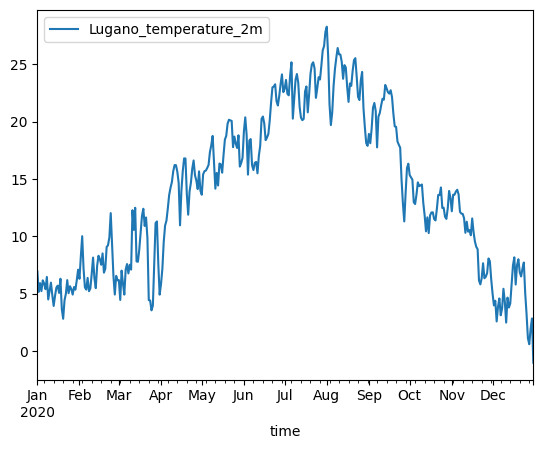

In [23]:
daily_average_temperature.plot()

In [24]:
comune = "Blenio"
latitude, longitude = get_coordinates(comune)

if latitude and longitude:
    print(f"coordinates - Latitude: {latitude}, Longitude: {longitude}")

coordinates - Latitude: 46.55192947387695, Longitude: 8.901261329650879
